<h1>Sparse Convolutional Denoising Autoencoders for Genotype Imputation <span class="tocSkip"></span></h1>

### ORIGINAL CODE FROM https://github.com/work-hard-play-harder/SCDA. Just change versiones of libraries or functions names wich have changed

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Loading data</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Preprocessing</a></span></li></ul></li><li><span><a href="#Method" data-toc-modified-id="Method-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Method</a></span><ul class="toc-item"><li><span><a href="#Build-model" data-toc-modified-id="Build-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Build model</a></span></li><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Plot</a></span></li></ul></li><li><span><a href="#Save-model" data-toc-modified-id="Save-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save model</a></span></li></ul></div>

# Introduction

This notebook is a case study of building a SCDA model by using completely convolutional layers with L1 regularization on the weigths, which achieves ~99% imputation accuracy on yeast genotype dataset.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import to_categorical

%matplotlib inline   
from matplotlib import pyplot as plt


In [2]:
# specify a seed for repeating the exact dataset splits
np.random.seed(seed=28213)

# Dataset

## Loading data

In [3]:
input_name = '../data/yeast_genotype_train.txt'
df_ori = pd.read_csv(input_name, sep='\t', index_col=0)
df_ori.shape

(3513, 28220)

In [4]:
df_ori.head()

,33070_chrI_33070_A_T,33147_chrI_33147_G_T,33152_chrI_33152_T_C,33200_chrI_33200_C_T,33293_chrI_33293_A_T,33328_chrI_33328_C_A,33348_chrI_33348_G_C,33403_chrI_33403_C_T,33502_chrI_33502_A_G,33548_chrI_33548_A_C,...,12048853_chrXVI_925593_G_C,12049199_chrXVI_925939_T_C,12049441_chrXVI_926181_C_T,12050613_chrXVI_927353_T_G,12051167_chrXVI_927907_A_C,12051240_chrXVI_927980_A_G,12051367_chrXVI_928107_C_T,12052782_chrXVI_929522_C_T,12052988_chrXVI_929728_A_G,12053130_chrXVI_929870_C_T
SAMID,,,,,,,,,,,,,,,,,,,,,
01_01,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
01_02,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
01_03,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
01_04,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
01_06,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


## Preprocessing

In [5]:
# one hot encode
df_onehot = to_categorical(df_ori)
df_onehot.shape

(3513, 28220, 3)

In [6]:
# split df to train and valid
train_X, valid_X = train_test_split(df_onehot, test_size=0.2)

train_X.shape, valid_X.shape

((2810, 28220, 3), (703, 28220, 3))

# Method

## Build model

In [7]:
# hyperparameters
missing_perc = 0.1

# training
batch_size = 32
lr = 1e-3
epochs = 10

# conv1D
feature_size = train_X.shape[1]
inChannel = train_X.shape[2]
kr = 1e-4
drop_prec = 0.25

In [8]:
SCDA = Sequential()
# encoder
SCDA.add(Conv1D(32, 5, padding='same',activation='relu',kernel_regularizer=l1(kr),input_shape=(feature_size, inChannel)))
SCDA.add(MaxPooling1D(pool_size=2))
SCDA.add(Dropout(drop_prec))
          
SCDA.add(Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
SCDA.add(MaxPooling1D(pool_size=2)) 
SCDA.add(Dropout(drop_prec))

# bridge
SCDA.add(Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=l1(kr)))

# decoder
SCDA.add(Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
SCDA.add(UpSampling1D(2)) 
SCDA.add(Dropout(drop_prec))
          
SCDA.add(Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))) 
SCDA.add(UpSampling1D(2))
SCDA.add(Dropout(drop_prec))

SCDA.add(Conv1D(inChannel, 5, activation='softmax', padding='same')) 


# compile
SCDA.compile(loss='categorical_crossentropy', 
                    optimizer='adam',
                    metrics=['accuracy'])

SCDA.summary()

/Users/celiacabello/miniconda3/envs/TFM/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28220, 32)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14110, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14110, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 14110, 64)      │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7055, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7055, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 7055, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 7055, 64)       │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 14110, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14110, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 14110, 32)      │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 28220, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28220, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 28220, 3)       │           483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,683 (405.01 KB)

 Trainable params: 103,683 (405.01 KB)

 Non-trainable params: 0 (0.00 B)

## Generate data 

In [9]:
# Generates data for denoising autoencoder.
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, x_dataset, missing_perc=0.1, shuffle=True):
        self.batch_size = batch_size
        self.x = x_dataset
        self.missing_perc = missing_perc
        self.shuffle = shuffle
        # triggered once at the very beginning as well as at the end of each epoch.
        self.on_epoch_end()

    def __len__(self):
        # Denote the number of batches per epoch
        return int(np.floor(self.x.shape[0] / self.batch_size))

    def __getitem__(self, index):
        # Generates one batch of data
        indexes = self.indexes[index * self.batch_size:(
            index + 1) * self.batch_size]
        self.x_missing = self.x[indexes].copy()

        # Generates missing genotypes
        # different missing loci for each individuals
        for i in range(self.x_missing.shape[0]):
            missing_size = int(self.missing_perc * self.x_missing.shape[1])
            missing_index = np.random.randint(
                self.x_missing.shape[1], size=missing_size)
            # missing loci are encoded as [0, 0]
            self.x_missing[i, missing_index, :] = [1, 0, 0]

        return self.x_missing, self.x[indexes]

    def on_epoch_end(self):
        # Update indexes after each epoch
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [12]:
train_generator = DataGenerator(
    batch_size=batch_size, x_dataset=train_X, missing_perc=missing_perc)
valid_generator = DataGenerator(
    batch_size=batch_size, x_dataset=valid_X, missing_perc=missing_perc)

## Training

In [19]:
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
# early stopping call back with val_loss monitor
EarlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

# model checkpoint call back with val_acc monitor
ModelCheckpoint = keras.callbacks.ModelCheckpoint(
    'models/SCDA_checkpoint.{epoch:02d}-{val_accuracy:.4f}.keras',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto')
    #period=1 => no reconoce el argumento, lo pongo en fit @celia

In [20]:
#function modified -- deprecation
SCDA_train = SCDA.fit(
    x=train_generator,  
    epochs=epochs,
    verbose=1,
    validation_data=valid_generator,  
    callbacks=[EarlyStopping, ModelCheckpoint]
)


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 68s 776ms/step - accuracy: 0.9981 - loss: 0.0674 - val_accuracy: 0.9995 - val_loss: 0.0498
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 67s 765ms/step - accuracy: 0.9982 - loss: 0.0477 - val_accuracy: 0.9995 - val_loss: 0.0368
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 69s 785ms/step - accuracy: 0.9982 - loss: 0.0363 - val_accuracy: 0.9995 - val_loss: 0.0289
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 70s 799ms/step - accuracy: 0.9982 - loss: 0.0290 - val_accuracy: 0.9995 - val_loss: 0.0237
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 70s 805ms/step - accuracy: 0.9983 - loss: 0.0243 - val_accuracy: 0.9994 - val_loss: 0.0200
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 67s 764ms/step - accuracy: 0.9983 - loss: 0.0209 - val_accuracy: 0.9995 - val_loss: 0.0174
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 66s 750ms/step - accuracy: 0.9983 - loss: 0.0185 - val_accuracy: 0.9995 - val_loss: 0.0154
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 70s 799ms/step - accuracy: 0.9984 - loss: 0.0167 - val_accu

## Plot

/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_46480/3792502754.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(loss)), loss,'b', label='Training loss', color="black")


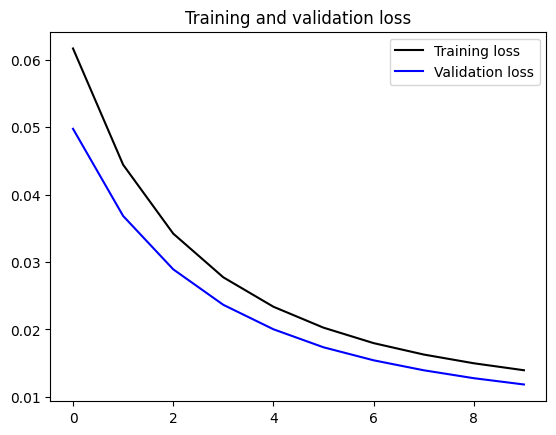

In [21]:
# plot loss curve on validation data
loss = SCDA_train.history['loss']
val_loss = SCDA_train.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss,'b', label='Training loss', color="black")
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_46480/2061072910.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(acc)), acc, 'b', label='Training acc', color="black")
/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_46480/2061072910.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc',color="blue")


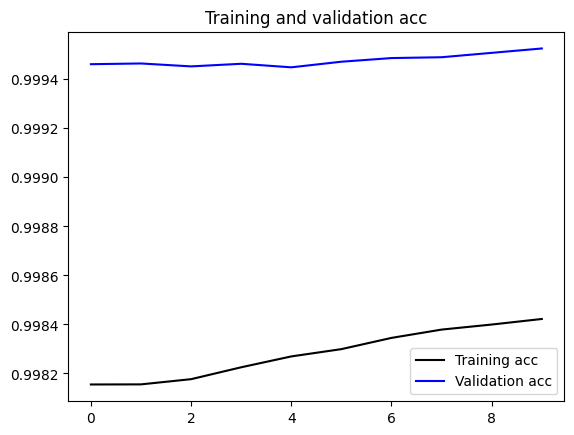

In [23]:
# function modified -- key "acc" did not exist. the correct key is 
# plot accuracy curve on validation data
print(SCDA_train.history.keys())
acc = SCDA_train.history['accuracy'] #initially the key was acc
val_acc = SCDA_train.history['val_accuracy']#initially the key was val_ acc
plt.figure()
plt.plot(range(len(acc)), acc, 'b', label='Training acc', color="black")
plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc',color="blue")
plt.title('Training and validation acc')
plt.legend()
plt.show()

### ADDED: See numerical final results

In [24]:
print("Final Training Loss:", loss[-1])
print("Final Validation Loss:", val_loss[-1])
print("Final Training Accuracy:", acc[-1])
print("Final Validation Accuracy:", val_acc[-1])

Final Training Loss: 0.013956730253994465
Final Validation Loss: 0.01184581033885479
Final Training Accuracy: 0.9984221458435059
Final Validation Accuracy: 0.9995255470275879


# Save model

In [27]:
SCDA.save('../models/SCDA_yeast.keras')  # change previous HDF5 file to keras

FileNotFoundError: [Errno 2] No such file or directory: '.../models/SCDA_yeast.keras'